## Assignment 2: Predicting how long will a user watch a stream?

VERY ROUGHT DRAFT OF WHAT OUR PROJECT IS AND WHAT WE ARE TRYING TO ACHIEVE

1. Identify the predictive task you will study

* dataset: Twitch interactions by Julian McAuley, twitch chat activity split by user, stream, stream nickname, and start/stop time in increments of 10 minutes.
* predict: How much time will a user stay on the stream 
* relevancy: By understanding how much time a user will watch a stream, we might tailor the ads better
* evaluation: MSE?, R squared

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

### Data Proccessing, EDA, and Feature Engineering
**Where is the Data From?  :** This datset originates from snapshots of Twitch.tv taken every 10 minutes for 43 days for the purpose of reccomender system research use. In this case it was used in a model named [LiveRec](https://github.com/JRappaz/liverec?tab=readme-ov-file).

The dataset anonymized users and took in stream IDs, names, and the times users appeared and left a stream chat.This data was collected from all available streams at the moment of the snapshot. So inactive streams are not collected at the time of the 10 minute interval. 

The processing was minimal as we really only translated the times given for `start` and `end` to give us the day of the week and time of day considering the fact that the snapshots were started at 12am on the first of the month.
 

##### FILE CAN BE DOWNLOADED AT THIS URL, IF YOU FOLLOW TO GDRIVE FOLDER: https://github.com/JRappaz/liverec?tab=readme-ov-file

I am thinking of not commiting the file here and just have a local copy on each one of ours laptops, easier to work with and doesnt require me uploading gupload module and setting up a url from gdive for a file

In [27]:
data = pd.read_csv('100k_a.csv')
data.head()

,user_idx,stream_idx,nickname,start,end
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594


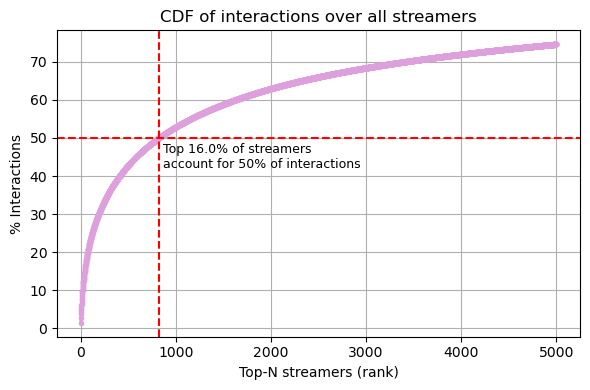

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

interaction_counts = data.groupby('nickname').size().sort_values(ascending=False)

total_interactions = interaction_counts.sum()
cum_pct = interaction_counts.head(5000).cumsum() / total_interactions * 100  # 0–100%

x = np.arange(1, len(cum_pct) + 1)

k_50 = np.argmax(cum_pct.values >= 50) + 1
y_50 = cum_pct.iloc[k_50 - 1]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, cum_pct.values, marker='.', linewidth=2, color = 'plum')

ax.axhline(50, linestyle='--', color = 'red')

ax.axvline(k_50, linestyle='--', color = 'red')

ax.text(
    k_50 * 1.05, 42,
    f"Top {np.round((k_50 / len(cum_pct) * 100), 0)}% of streamers\naccount for 50% of interactions",
    fontsize=9
)

ax.set_xlabel("Top-N streamers (rank)")
ax.set_ylabel("% Interactions")
ax.set_title("CDF of interactions over all streamers")
ax.grid(True)

plt.tight_layout()
plt.show()


#### Note to self, maybe this could be an idea for a baseline since most interactions and assuming time spent are on big players that mignt be the baseline

In [29]:
data['duration'] = (data['end'] - data['start']) * 10

data['starting_time'] = data['start'].apply(lambda x: datetime(2025, 1, 1) + timedelta(minutes=x * 10))
data['day_of_week'] = data['starting_time'].dt.day_name()

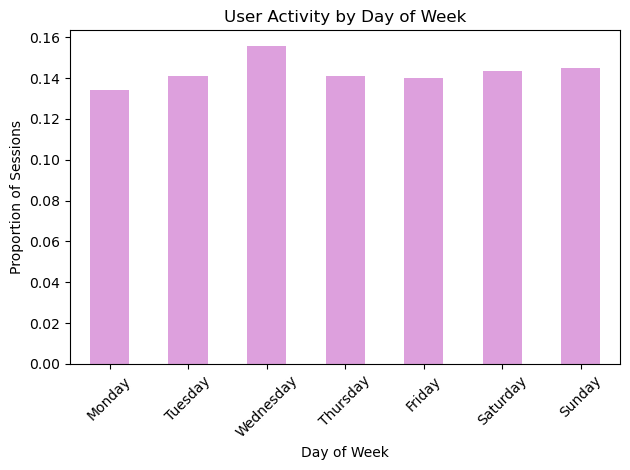

In [30]:
import matplotlib.pyplot as plt

day_counts = data['day_of_week'].value_counts(normalize=True)
calendar_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_counts = day_counts.reindex(calendar_order)
day_counts.plot(kind='bar', color = 'plum')
plt.title("User Activity by Day of Week")
plt.ylabel("Proportion of Sessions")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Note to self: Day of the week might not be a great feature, not a lot of variety

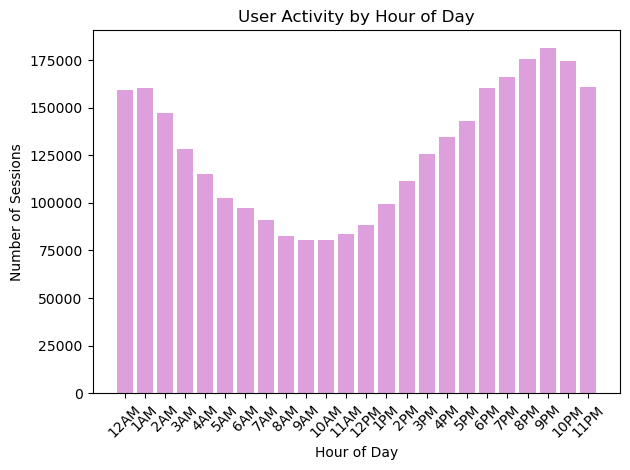

In [31]:
data['hour_of_day'] = data['starting_time'].dt.hour
hour_counts = data['hour_of_day'].value_counts().sort_index()
ampm_labels = [f"{(h % 12 or 12)}{'AM' if h < 12 else 'PM'}" for h in hour_counts.index]

plt.bar(ampm_labels, hour_counts, color='plum')

plt.title("User Activity by Hour of Day")
plt.ylabel("Number of Sessions")
plt.xlabel("Hour of Day")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Note to self: a lot of variety can be a good predictor

### How can baselines look like?

These should be based off lecture material or hw/assignments (assuming these are the rules)


* Naive predictor, prdicting global average, streamer average time, user averag time
* Collaborative filtering, rows = users, columns = streams, values = duration

In [32]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def R_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    if ss_total == 0:
        return 1.0 if ss_residual == 0 else 0.0
    return 1 - (ss_residual / ss_total)

X = data.loc[:, data.columns != 'duration']
y = data['duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline: Global Average predictor

In [37]:
def predict_global_average(dataset):
    return np.mean(dataset['duration'])

print("Global Average Duration:", predict_global_average(data))
print("MSE for Global Average Predictor:", RMSE(y_test, [predict_global_average(data)] * len(y_test)))
print("R² for Global Average Predictor:", R_squared(y_test, [predict_global_average(data)] * len(y_test)))

Global Average Duration: 31.420543671415555
MSE for Global Average Predictor: 42.50658777182824
R² for Global Average Predictor: -5.231319719634087e-07


### Baseline: Latent factor model

The problem: matrix vary sparse, 100K users, with each only watcing on aevrrage like 

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = data.copy()

# Split off test (10%)
df_trainval, df_test = train_test_split(
    df, test_size=0.1, random_state=42
)

# Split trainval into train (80%) and val (10%)
df_train, df_val = train_test_split(
    df_trainval, test_size=0.1111, random_state=42
)

print("Train size:", len(df_train))
print("Val size  :", len(df_val))
print("Test size :", len(df_test))


# Use full df to get max indices
n_users  = int(df['user_idx'].max()) + 1
n_items  = int(df['stream_idx'].max()) + 1
print("n_users:", n_users, "n_items:", n_items)

def prep_split(split_df):
    out = split_df.copy()
    out['u'] = out['user_idx'].astype('int64')
    out['i'] = out['stream_idx'].astype('int64')
    # Target: log1p(duration) to handle heavy tail
    out['y'] = np.log1p(out['duration'].astype('float32'))
    return out[['u', 'i', 'y']]

train_df = prep_split(df_train)
val_df   = prep_split(df_val)
test_df  = prep_split(df_test)

def train_mf(train_df, n_users, n_items,
             n_factors=32,
             n_epochs=10,
             lr=0.005,
             reg=0.05,
             val_df=None,
             verbose=True):
    """
    Biased Matrix Factorization with SGD.

    train_df / val_df must have columns: 'u', 'i', 'y'
    'y' here is log1p(duration).
    """
    # Global mean
    mu = train_df['y'].mean().astype('float32')

    # Biases and latent factors
    bu = np.zeros(n_users, dtype=np.float32)
    bi = np.zeros(n_items, dtype=np.float32)
    P  = 0.01 * np.random.randn(n_users, n_factors).astype(np.float32)
    Q  = 0.01 * np.random.randn(n_items, n_factors).astype(np.float32)

    # Training arrays
    train_u = train_df['u'].to_numpy(dtype=np.int64)
    train_i = train_df['i'].to_numpy(dtype=np.int64)
    train_y = train_df['y'].to_numpy(dtype=np.float32)

    if val_df is not None:
        val_u = val_df['u'].to_numpy(dtype=np.int64)
        val_i = val_df['i'].to_numpy(dtype=np.int64)
        val_y = val_df['y'].to_numpy(dtype=np.float32)

    def predict_batch(u_idx, i_idx):
        return (mu
                + bu[u_idx]
                + bi[i_idx]
                + np.sum(P[u_idx] * Q[i_idx], axis=1))

    for epoch in range(1, n_epochs + 1):
        # Shuffle training interactions each epoch
        idx = np.random.permutation(len(train_u))
        u_shuf = train_u[idx]
        i_shuf = train_i[idx]
        y_shuf = train_y[idx]

        for u, it, y_true in zip(u_shuf, i_shuf, y_shuf):
            # Current prediction
            pred = mu + bu[u] + bi[it] + np.dot(P[u], Q[it])
            err = y_true - pred

            # Clip error to avoid exploding gradients
            err = float(np.clip(err, -10.0, 10.0))

            # Save copies for updates
            Pu = P[u].copy()
            Qi = Q[it].copy()

            # Update biases
            bu[u] += lr * (err - reg * bu[u])
            bi[it] += lr * (err - reg * bi[it])

            # Update latent factors
            P[u] += lr * (err * Qi - reg * Pu)
            Q[it] += lr * (err * Pu - reg * Qi)

        if verbose:
            train_pred = predict_batch(train_u, train_i)
            train_mse  = np.mean((train_y - train_pred) ** 2)

            if val_df is not None:
                val_pred = predict_batch(val_u, val_i)
                val_mse  = np.mean((val_y - val_pred) ** 2)
                ss_tot   = np.sum((val_y - val_y.mean()) ** 2)
                ss_res   = np.sum((val_y - val_pred) ** 2)
                val_r2   = 1 - ss_res / ss_tot
                print(f"Epoch {epoch:02d}  train_MSE={train_mse:.4f}  "
                      f"val_MSE={val_mse:.4f}  val_R²={val_r2:.4f}")

    model = {'mu': mu, 'bu': bu, 'bi': bi, 'P': P, 'Q': Q}
    return model

def mf_predict_batch(u_idx, i_idx, model):
    """
    Predict log1p(duration) for arrays of user/item indices.
    """
    mu = model['mu']
    bu = model['bu']
    bi = model['bi']
    P  = model['P']
    Q  = model['Q']
    return (mu
            + bu[u_idx]
            + bi[i_idx]
            + np.sum(P[u_idx] * Q[i_idx], axis=1))


mf_model = train_mf(
    train_df=train_df,
    n_users=n_users,
    n_items=n_items,
    n_factors=64,   # you can try 16/32/64 later
    n_epochs=8,
    lr=0.005,
    reg=0.05,
    val_df=val_df,
    verbose=True
)

y_true_test = df_test['duration'].to_numpy(dtype=np.float32)

# Predicted log1p(duration)
u_test = test_df['u'].to_numpy(dtype=np.int64)
i_test = test_df['i'].to_numpy(dtype=np.int64)
y_pred_log_test = mf_predict_batch(u_test, i_test, mf_model)

# Back to original duration
y_pred_test = np.expm1(y_pred_log_test)
rmse_test = RMSE(y_true_test, y_pred_test)
r2_test  = r2_score(y_true_test, y_pred_test)
print("\n=== FINAL TEST PERFORMANCE (original duration units) ===")
print("Test MSE:", rmse_test)
print("Test R² :", r2_test)


Train size: 2441416
Val size  : 305143
Test size : 305174
n_users: 100000 n_items: 739991
Epoch 01  train_MSE=0.6048  val_MSE=0.6169  val_R²=0.0811
Epoch 02  train_MSE=0.5738  val_MSE=0.5938  val_R²=0.1155
Epoch 03  train_MSE=0.5547  val_MSE=0.5811  val_R²=0.1345
Epoch 04  train_MSE=0.5413  val_MSE=0.5731  val_R²=0.1463
Epoch 05  train_MSE=0.5311  val_MSE=0.5678  val_R²=0.1542
Epoch 06  train_MSE=0.5230  val_MSE=0.5641  val_R²=0.1597
Epoch 07  train_MSE=0.5163  val_MSE=0.5613  val_R²=0.1638
Epoch 08  train_MSE=0.5105  val_MSE=0.5594  val_R²=0.1668

=== FINAL TEST PERFORMANCE (original duration units) ===
Test MSE: 41.216366
Test R² : 0.05554431676864624


In [ ]:
# 1) global mean
mu = df_train['duration'].mean()

### Baseline Bias Model

In [32]:
# 2) item biases with shrinkage
lambda_i = 20  # regularization strength
item_stats = df_train.groupby('stream_idx').agg(
    n=('duration', 'size'),
    sum=('duration', 'sum')
)
item_stats['b_i'] = (item_stats['sum'] - item_stats['n'] * mu) / (item_stats['n'] + lambda_i)

# 3) user biases with shrinkage
lambda_u = 20
user_stats = df_train.join(item_stats['b_i'], on='stream_idx')
user_stats = user_stats.groupby('user_idx').agg(
    n=('duration', 'size'),
    sum=('duration', 'sum'),
    bi_sum=('b_i', 'sum')
)
user_stats['b_u'] = (user_stats['sum'] - mu * user_stats['n'] - user_stats['bi_sum']) / (user_stats['n'] + lambda_u)


def predict_bias_model(user_idx, stream_idx):
    bu = user_stats['b_u'].get(user_idx, 0.0)
    bi = item_stats['b_i'].get(stream_idx, 0.0)
    return mu + bu + bi


y_true_test = df_test['duration'].to_numpy(dtype=np.float32)
y_pred_test = np.array([
    predict_bias_model(u, i)
    for u, i in zip(test_df['u'], test_df['i'])
], dtype=np.float32)
rmse_test = RMSE(y_true_test, y_pred_test)
r2_test  = r2_score(y_true_test, y_pred_test)
print("\n=== FINAL TEST PERFORMANCE (original duration units) ===")
print("Test RMSE:", rmse_test)
print("Test R² :", r2_test)


=== FINAL TEST PERFORMANCE (original duration units) ===
Test RMSE: 39.00479
Test R² : 0.15417969226837158


### Baseline Temporal Model

In [33]:
# hour bias
hour_stats = df_train.groupby('hour_of_day')['duration'].agg(['size', 'mean'])
lambda_h = 20
hour_stats['b_h'] = (hour_stats['mean'] - mu) * (hour_stats['size'] / (hour_stats['size'] + lambda_h))

# day-of-week bias
dow_stats = df_train.groupby('day_of_week')['duration'].agg(['size', 'mean'])
lambda_d = 20
dow_stats['b_d'] = (dow_stats['mean'] - mu) * (dow_stats['size'] / (dow_stats['size'] + lambda_d))

def predict_with_temporal(user_idx, stream_idx, hour_of_day, day_of_week):
    bu = user_stats['b_u'].get(user_idx, 0.0)
    bi = item_stats['b_i'].get(stream_idx, 0.0)
    bh = hour_stats['b_h'].get(hour_of_day, 0.0)
    bd = dow_stats['b_d'].get(day_of_week, 0.0)
    return mu + bu + bi + bh + bd

y_true_test = df_test['duration'].to_numpy(dtype=np.float32)
y_pred_test = np.array([
    predict_with_temporal(u, i, h, d)
    for u, i, h, d in zip(
        test_df['u'],
        test_df['i'],
        df_test['hour_of_day'],
        df_test['day_of_week']
    )
], dtype=np.float32)
rmse_test = RMSE(y_true_test, y_pred_test)
r2_test  = r2_score(y_true_test, y_pred_test)
print("\n=== FINAL TEST PERFORMANCE (original duration units) ===")
print("Test RMSE:", rmse_test)
print("Test R² :", r2_test)


=== FINAL TEST PERFORMANCE (original duration units) ===
Test RMSE: 39.004444
Test R² : 0.1541946530342102


In [36]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error, r2_score

# ============================================================
# Assumptions:
# - You already have df_all with at least:
#     'user_idx', 'stream_idx', 'duration'
# - You already split into df_train, df_val, df_test
#   (if not, you can just treat df_all as df_train for now)
# ============================================================

# Just to be explicit here:
train = df_train.copy()
val   = df_val.copy()
test  = df_test.copy()

# Make sure indices are ints
train['user_idx'] = train['user_idx'].astype(int)
train['stream_idx'] = train['stream_idx'].astype(int)
test['user_idx'] = test['user_idx'].astype(int)
test['stream_idx'] = test['stream_idx'].astype(int)

n_users = int(df_train['user_idx'].max()) + 1
n_items = int(df_train['stream_idx'].max()) + 1

print("n_users:", n_users, "n_items:", n_items)

# ============================================================
# 1. Build sparse user–item matrix from TRAIN only
# ============================================================

R = csr_matrix(
    (train['duration'].astype(float),
     (train['user_idx'], train['stream_idx'])),
    shape=(n_users, n_items)
)

# Item norms for cosine similarity: ||item_j||
# R.power(2).sum(axis=0) -> (1, n_items) matrix
item_norms = np.sqrt(np.asarray(R.power(2).sum(axis=0)).ravel())  # shape (n_items,)

# Global mean and item means for fallbacks
global_mean = train['duration'].mean()

item_stats = train.groupby('stream_idx')['duration'].agg(['mean', 'size'])
item_mean = item_stats['mean'].to_dict()

# ============================================================
# 2. Item–item CF prediction function (fixed .A1 -> toarray().ravel())
# ============================================================

def predict_item_item_cf(u_idx, i_idx, R, item_norms,
                         k=50, min_sim=0.0):
    """
    Predict duration for (user u_idx, item i_idx) using
    item–item CF with cosine similarity on TRAIN data.

    R: csr_matrix of shape (n_users, n_items)
    item_norms: precomputed L2 norm of each item column
    k: number of neighbors
    min_sim: minimum similarity threshold
    """
    # Streams this user has watched (in TRAIN)
    user_row = R[u_idx]          # 1 x n_items sparse
    user_items = user_row.indices

    # If user has no history in TRAIN, fall back to item or global mean
    if user_items.size == 0:
        return item_mean.get(i_idx, global_mean)

    # If the target item never appears in TRAIN, use global mean / user mean
    if item_norms[i_idx] == 0:
        user_durs = user_row.data
        if user_durs.size > 0:
            return float(user_durs.mean())
        return item_mean.get(i_idx, global_mean)

    # Column vector for target item i
    col_i = R[:, i_idx]  # shape (n_users, 1), sparse

    # Compute cosine similarity between i and each item the user has watched:
    # sim(i, j) = (R[:,i]^T R[:,j]) / (||i|| * ||j||)
    # Only compare against items in user_items.
    numerators_mat = col_i.T.dot(R[:, user_items])      # 1 x (#user_items)
    numerators = np.asarray(numerators_mat.toarray()).ravel()

    denom = item_norms[i_idx] * item_norms[user_items]
    sims = np.zeros_like(numerators)
    valid = denom > 0
    sims[valid] = numerators[valid] / denom[valid]

    # Top-k most similar items
    if sims.size > k:
        topk_idx = np.argpartition(sims, -k)[-k:]
    else:
        topk_idx = np.arange(sims.size)

    sims_k = sims[topk_idx]
    items_k = user_items[topk_idx]

    # Filter low/negative similarities
    mask = sims_k > min_sim
    sims_k = sims_k[mask]
    items_k = items_k[mask]

    if sims_k.size == 0:
        return item_mean.get(i_idx, global_mean)

    # Durations that user u gave to these neighbor items
    neighbor_vals_mat = user_row[:, items_k]  # 1 x (#neighbors)
    neighbor_vals = np.asarray(neighbor_vals_mat.toarray()).ravel()

    # Weighted average
    pred = float(np.dot(sims_k, neighbor_vals) / sims_k.sum())
    return pred

# ============================================================
# 3. Evaluate item–item CF on the TEST set
# ============================================================

def evaluate_item_item_cf(df_test, R, item_norms, k=50, min_sim=0.0):
    y_true = df_test['duration'].to_numpy(dtype=float)
    preds = []

    for _, row in df_test.iterrows():
        u = int(row['user_idx'])
        i = int(row['stream_idx'])
        p = predict_item_item_cf(u, i, R, item_norms, k=k, min_sim=min_sim)
        preds.append(p)

    y_pred = np.array(preds, dtype=float)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2, y_pred

mse_cf, rmse_cf, r2_cf, y_pred_cf = evaluate_item_item_cf(
    test, R, item_norms, k=50, min_sim=0.0
)

print("Item–item CF TEST MSE :", mse_cf)
print("Item–item CF TEST RMSE:", rmse_cf)
print("Item–item CF TEST R²  :", r2_cf)


n_users: 100000 n_items: 739991


KeyboardInterrupt: 

In [34]:
### Decision Tree Baseline ###
### Not suitable as is at all, feature engineering would improve this
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

for col in ['user_idx', 'stream_idx', 'nickname']: ### IMPORTANT: converts strings to numeric IDs, so will not appear as their streamer names anymore
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

#train test split
X = df[['user_idx', 'stream_idx', 'nickname']]
y = df['duration']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#start with shallow depth for baseline (dont wan to overfit either)
dt = DecisionTreeRegressor(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Decision Tree RMSE: {rmse:.2f}")
print(f"Baseline Decision Tree R²: {r2:.3f}")

Baseline Decision Tree RMSE: 42.38
Baseline Decision Tree R²: 0.006


C:\Users\edgar\miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
### Linear Regression Baseline ###
### Not suitable for this task, but just to take a look
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression RMSE: {rmse:.2f}")
print(f"Baseline Linear Regression R²: {r2:.3f}")

Baseline Linear Regression RMSE: 42.49
Baseline Linear Regression R²: 0.001


C:\Users\edgar\miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
### Random Forest Baseline
from sklearn.ensemble import RandomForestRegressor

# Random Forest baseline
rf = RandomForestRegressor(
    n_estimators=100,       # number of trees
    max_depth=None,         # let trees grow fully
    min_samples_leaf=10,    # regularization
    n_jobs=-1,              # use all cores
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

C:\Users\edgar\miniforge3\envs\dsc80\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R²: {r2:.3f}")

Random Forest RMSE: 41.78
Random Forest R²: 0.034


### Feature Engineering

Going beyond using averages for our naive solutions, we can consider more specific situations and statistics. 

For the user end, we can consider how many streams a user has watched, how long they typically stay on a stream, and even more specifically, how long they typically watch specific streamers.

For the streamer side, we can consider how many streams a streamer has and their average viewer retention time.

In [36]:
# Features beyond baselines
df['user_mean'] = df.groupby('user_idx')['duration'].transform('mean')       #how long a user stays on a stream avg
df['stream_mean'] = df.groupby('stream_idx')['duration'].transform('mean')   #avg retention of a stream/streamer
df['user_count'] = df.groupby('user_idx')['duration'].transform('count')     #how many watch sessions one user has
df['stream_count'] = df.groupby('stream_idx')['duration'].transform('count') #how many streams a streamer has
df['user_stream_mean'] = df.groupby(['user_idx', 'stream_idx'])['duration'].transform('mean') #avg time a specific user watches a specific streamer

# Modeling

In [40]:
## Current State of the Dataframe
df.head()

,user_idx,stream_idx,nickname,start,end,duration,starting_time,day_of_week,hour_of_day,user_mean_duration,user_session_count,stream_mean_duration,stream_popularity,nickname_mean_duration,user_mean,stream_mean,user_count,stream_count,user_stream_mean
0,0,19634,92273,154,156,20,2025-01-02 01:40:00,Thursday,1,23.4,50,14.880952,84,25.567823,23.4,14.880952,50,84,20.0
1,0,24110,5331,166,169,30,2025-01-02 03:40:00,Thursday,3,23.4,50,33.478261,23,20.000000,23.4,33.478261,50,23,30.0
2,0,70061,92273,587,588,10,2025-01-05 01:50:00,Sunday,1,23.4,50,17.560976,82,25.567823,23.4,17.560976,50,82,10.0
3,0,71305,155056,589,591,20,2025-01-05 02:10:00,Sunday,2,23.4,50,14.246575,73,23.604561,23.4,14.246575,50,73,20.0
4,0,73807,68370,591,594,30,2025-01-05 02:30:00,Sunday,2,23.4,50,25.000000,10,30.129032,23.4,25.000000,50,10,30.0


**Problem we want to solve:** Predicting a viewer's watch time (A regression task)

The dataset provides these columns (We added the labels):
    
    - user_idx : User ID
    - stream_idx : Stream ID
    - nickname : name of streamer
    - start : when this user is first seen in chat
    - end : when this user's session was seen gone from chat

From this we formulated features for our inputs such as:

    - user_mean: Average time this user spends on a stream
    - stream_mean: Avg user retention time this stream has
    - user_count: How many watch sessions a user has
    - stream_count: How many streams a streamer has
    - user_stream_mean: Avg time a user spends watching a specific streamer
    
Suitable Models:

    - Regression
    - Random Forests
    - Temporal Based Models